In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# load preprocessed amazon review dataset from directory
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/preprocessed_news.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))
data.sample(20)

전체 샘플수 : 98360


,headlines,text
61165,jandk chenab rail bridge stand quakes blasts r...,world highest bridge currently construction ch...
74884,tejashwi sits midnight dharna district admin,rjd leader tejashwi yadav sat midnight dharna ...
1994,kerala government conduct sabarimala shameful ...,hitting cpi led kerala government pm narendra ...
31610,doctor treats soldiers free says pay fee border,doctor ajay chaudhary son veteran army man tre...
28382,rohit hits ninety seven india beat ireland win...,rohit sharma slammed ninety seven runs sixty o...
21024,omar abdullah donate one month salary kerala f...,former jammu kashmir chief minister omar abdul...
85974,sixteen year old bengaluru girl get planet named,minor planet milky way galaxy would named sixt...
72965,rotis condoms recovered dera sacha sauda headq...,haryana police recovered bundles rotis condoms...
44266,woman kills mom opposing relation female teacher,eighteen year old woman allegedly killed mothe...
89225,topic redundant madhuri rumoured ex boyfriend ...,actress madhuri dixit said topic rumoured ex b...


### 데이터 전처리

##### 1) train / test split

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 95
텍스트의 평균 길이 : 38.582035380235865
요약문의 최소 길이 : 1
요약문의 최대 길이 : 23
요약문의 평균 길이 : 7.899339162261081


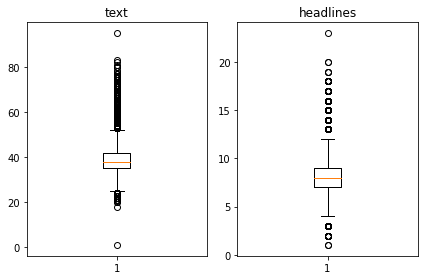

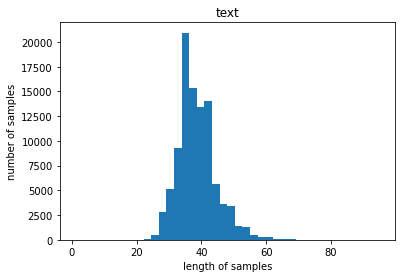

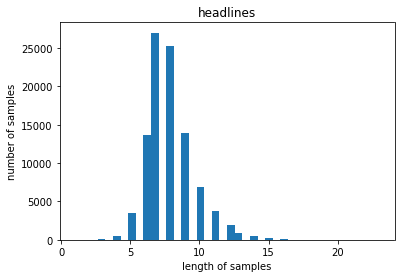

In [12]:
# 샘플의 텍스트/요약문 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약문의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약문의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약문의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [13]:
# mean + 2*std를 텍스트 길이의 상한선으로 설정 -> 손실되는 text 5% 미만
text_max_len = int(np.mean(text_len) + 2 * np.std(text_len))
print(text_max_len)

summary_max_len = int(np.mean(summary_len) + 2 * np.std(summary_len))
print(summary_max_len)

50
11


In [14]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [15]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9583367222448149
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9613359089060594


In [16]:
data = data[(data["text"].apply(lambda x: len(x.split()) <= text_max_len)) & 
(data["headlines"].apply(lambda x: len(x.split()) <= summary_max_len))]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 91643


In [17]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al ninety pe...,saurav kant alumnus upgrad iit pg program mach...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al ninety pe...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food swiggy on...,delhi techie wins free food swiggy one year cr...
2,new zealand end rohit sharma led india twelve ...,new zealand defeated india eight wickets fourt...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india twelve ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken


In [18]:
# numpy array로 저장
encoder_input = np.array(data['text']) 
decoder_input = np.array(data['decoder_input']) 
decoder_target = np.array(data['decoder_target']) 

In [19]:
en_x_train, en_x_test, de_x_train, de_x_test, de_y_train, de_y_test = train_test_split(
    encoder_input, decoder_input, decoder_target, test_size=0.2)

In [20]:
print('훈련 데이터의 개수 :', len(en_x_train))
print('훈련 레이블의 개수 :', len(de_x_train))
print('테스트 데이터의 개수 :', len(en_x_test))
print('테스트 레이블의 개수 :', len(de_x_test))

훈련 데이터의 개수 : 73314
훈련 레이블의 개수 : 73314
테스트 데이터의 개수 : 18329
테스트 레이블의 개수 : 18329


##### 2) 정수 인코딩

In [21]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(en_x_train)

In [22]:
threshold = 9
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68349
등장 빈도가 8번 이하인 희귀 단어의 수: 49484
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 18865
단어 집합에서 희귀 단어의 비율: 72.39901095846318
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.153898375743118


In [23]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20000으로 제한
src_tokenizer.fit_on_texts(en_x_train) # 단어 집합 재생성

In [24]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
en_x_train = src_tokenizer.texts_to_sequences(en_x_train) 
en_x_test = src_tokenizer.texts_to_sequences(en_x_test)

# 잘 진행되었는지 샘플 출력
print(en_x_train[:3])

[[146, 4737, 2785, 1694, 550, 345, 2939, 4041, 18866, 5973, 3468, 5661, 3081, 2206, 3769, 9719, 227, 146, 1, 861, 17, 2401, 345, 3082, 6, 233, 394, 3380, 345, 366, 1386, 315, 3065], [459, 63, 1003, 618, 83, 962, 164, 9, 22, 114, 1632, 13822, 12138, 504, 4560, 12882, 9720, 2, 3, 81, 511, 962, 5722, 2621, 15, 10, 962, 1085, 59, 164, 22, 12138, 326, 2004, 1003, 363, 102, 962, 2621, 1166, 34, 259, 114], [592, 2468, 628, 6117, 855, 7, 523, 23, 15490, 149, 6567, 855, 7, 167, 1011, 18867, 15491, 32, 3794, 2031, 1939, 1853, 855, 10145, 328, 4, 3, 48, 177, 67, 602, 10145, 42, 25, 35, 116, 177, 465, 434]]


In [25]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(de_x_train)

In [26]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29788
등장 빈도가 5번 이하인 희귀 단어의 수: 19658
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10130
단어 집합에서 희귀 단어의 비율: 65.9930173224117
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.898631439428523


In [27]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(de_x_train)
tar_tokenizer.fit_on_texts(de_y_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
de_x_train = tar_tokenizer.texts_to_sequences(de_x_train) 
de_y_train = tar_tokenizer.texts_to_sequences(de_y_train)
de_x_test = tar_tokenizer.texts_to_sequences(de_x_test)
de_y_test = tar_tokenizer.texts_to_sequences(de_y_test)

# 잘 변환되었는지 확인
print('decoder input: ', de_x_train[:5])
print('decoder target: ', de_y_train[:5])

decoder input:  [[1, 124, 294, 921, 4137, 4009], [1, 7422, 7423, 1184, 1600, 134, 531, 7424], [1, 2241, 3156, 779, 5, 7, 109, 855, 7927, 536, 26], [1, 18, 470, 84, 3014, 180], [1, 44, 69, 99, 565, 1518, 2045, 43]]
decoder target:  [[124, 294, 921, 4137, 4009, 2], [7422, 7423, 1184, 1600, 134, 531, 7424, 2], [2241, 3156, 779, 5, 7, 109, 855, 7927, 536, 26, 2], [18, 470, 84, 3014, 180, 2], [44, 69, 99, 565, 1518, 2045, 43, 2]]


In [28]:
drop_train = [index for index, sentence in enumerate(de_x_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(de_x_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

en_x_train = [sentence for index, sentence in enumerate(en_x_train) if index not in drop_train]
de_x_train = [sentence for index, sentence in enumerate(de_x_train) if index not in drop_train]
de_y_train = [sentence for index, sentence in enumerate(de_y_train) if index not in drop_train]

en_x_test = [sentence for index, sentence in enumerate(en_x_test) if index not in drop_test]
de_x_test = [sentence for index, sentence in enumerate(de_x_test) if index not in drop_test]
de_y_test = [sentence for index, sentence in enumerate(de_y_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(en_x_train))
print('훈련 레이블의 개수 :', len(de_x_train))
print('테스트 데이터의 개수 :', len(en_x_test))
print('테스트 레이블의 개수 :', len(de_x_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 73313
훈련 레이블의 개수 : 73313
테스트 데이터의 개수 : 18328
테스트 레이블의 개수 : 18328


In [29]:
en_x_train = pad_sequences(en_x_train, maxlen=text_max_len, padding='post')
en_x_test = pad_sequences(en_x_test, maxlen=text_max_len, padding='post')
de_x_train = pad_sequences(de_x_train, maxlen=summary_max_len, padding='post')
de_x_test = pad_sequences(de_x_test, maxlen=summary_max_len, padding='post')
de_y_train = pad_sequences(de_y_train, maxlen=summary_max_len, padding='post')
de_y_test = pad_sequences(de_y_test, maxlen=summary_max_len, padding='post')

### 모델 설계

In [67]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

##### Encoder

In [68]:
embedding_dim = 256
hidden_size = 512

# 인코더 input
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

##### Decoder

In [69]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

In [70]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 50, 256)      5120000     input_11[0][0]                   
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 50, 512), (N 1574912     embedding_4[0][0]                
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

In [71]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output3])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 50, 256)      5120000     input_11[0][0]                   
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 50, 512), (N 1574912     embedding_4[0][0]                
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

### training & test

##### training

In [72]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=1, verbose=1)
history = model.fit(x=[en_x_train, de_x_train], y=de_y_train, \
          validation_data=([en_x_test, de_x_test], de_y_test), \
          batch_size=512, callbacks=[es], epochs=50)

Epoch 1/50
144/144 [==============================] - 76s 495ms/step - loss: 5.6339 - val_loss: 5.2135
Epoch 2/50
144/144 [==============================] - 71s 492ms/step - loss: 5.2227 - val_loss: 5.0813
Epoch 3/50
144/144 [==============================] - 71s 495ms/step - loss: 5.0585 - val_loss: 4.9256
Epoch 4/50
144/144 [==============================] - 71s 496ms/step - loss: 4.8809 - val_loss: 4.8039
Epoch 5/50
144/144 [==============================] - 72s 498ms/step - loss: 4.6646 - val_loss: 4.5786
Epoch 6/50
144/144 [==============================] - 72s 498ms/step - loss: 4.4277 - val_loss: 4.4103
Epoch 7/50
144/144 [==============================] - 72s 498ms/step - loss: 4.2092 - val_loss: 4.2362
Epoch 8/50
144/144 [==============================] - 72s 498ms/step - loss: 3.9719 - val_loss: 4.0683
Epoch 9/50
144/144 [==============================] - 72s 499ms/step - loss: 3.7302 - val_loss: 3.9450
Epoch 10/50
144/144 [==============================] - 72s 499ms/step - l

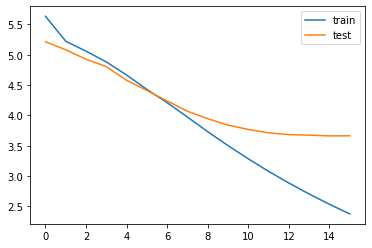

In [73]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

##### inference

In [74]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어

inference model design

In [75]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [76]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [77]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [78]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0) and i!=tar_word_to_index['sostoken'] and i!=tar_word_to_index['eostoken']:
            temp = temp + tar_index_to_word[i]+' '
    return temp

In [79]:
for i in range(100, 151):
    print("원문 :", seq2text(en_x_test[i]))
    print("실제 요약 :", seq2summary(de_x_test[i]))
    print("예측 요약 :", decode_sequence(en_x_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : chinese bike sharing startup bike shut five months launching ninety percents one thousand two hundred bikes stolen startup reportedly incurred loss ninety five lakh period founder lei said startup bikes went missing failed install gps devices cycles 
실제 요약 : bike sharing startup shuts five months ninety percents bikes stolen 
예측 요약 :  china plans expand delivery service startup


원문 : twenty eight year old man paid forty seat travelled alone plane greece england person booked seat one hundred sixty eight seater plane show airline crew allowed sit cockpit also played songs public address system used make announcements 
실제 요약 : man gets one hundred sixty eight plane forty ticket 
예측 요약 :  man hides gold seat gets hides flight


원문 : commerce startup snapdeal reportedly received approval investors like ratan tata temasek blackrock foxconn sale larger rival flipkart however deal still final approval ontario teachers pension plan report said earlier week snapdeal board reportedly accep

예측 요약 :  french prez wife calls kim kardashian


원문 : video shows forty year old letting five metre long python wrap around head safety demonstration thailand explaining children snake around snake wants eat people lock quickly colleague heard saying 
실제 요약 : man lets five metre long python wrap around safety demo 
예측 요약 :  video man walks getting floor


원문 : bengaluru based lifestyle brand reportedly raised dollars thirteen point one million funding round led mumbai based private equity firm gaja capital round also saw participation existing investors matrix partners founded two thousand ten sells designer shirts coffee shot glasses mouse pads posters among others 
실제 요약 : lifestyle brand raises dollars thirteen million funding 
예측 요약 :  bengaluru based startup raises dollars one point five million


원문 : suresh raina made comeback team india year last month sang bollywood song ye mastani team hotel colombo bcci shared video raina singing song captioned seen field ever seen sing kish

예측 요약 :  train train derails mumbai


원문 : suicide bomb attack carried taliban targetting nato convoy killed two us soldiers southern afghan city kandahar wednesday pentagon spokesperson said attack comes twenty nine people killed sixty four others injured explosion tuesday inside minority shi ite muslim mosque western afghanistan 
실제 요약 : taliban attack nato convoy kills two us soldiers 
예측 요약 :  taliban attack afghan afghan peace peace


원문 : cbse officials denied reports class twelve economics paper leaked hours exam monday urging students parents panic cbse best ensure sanctity examination officials said earlier march fifteen reports alleged paper leaked however cbse later denied 
실제 요약 : cbse denies reports class twelve economics paper leaked 
예측 요약 :  cbse class twelve exam paper leak cbse exam


원문 : apple supplier china catcher technology factory accused chemical safety overtime violations workers according china labor watch report says catcher workers stand ten hours day handl

### 추출적 요약 결과와 비교해보기(with 매트릭스 시놉시스 데이터셋)

In [80]:
import requests
from summa.summarizer import summarize

In [81]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [82]:
# 전체 문장의 0.5%만 요약문으로 추출
print('Summary:', summarize(text, ratio=0.005))

Summary: Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [83]:
# list 형태로 출력
print(summarize(text, ratio=0.005, split=True))

['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [84]:
# 요약문에 포함된 단어 수를 50개로 제한
print(summarize(text, words=50))

Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


### Done

1. 데이터 전처리 함수
- 수치 데이터와 일부 특수기호도 중요한 정보인데 이것도 없애야 할까?
    - $ → ‘dollar’, % → ‘percent’, & → ‘and’로 변경하는 로직 추가
    - num2words 라이브러리로 숫자를 문자로 변경 (ex : 2000 → two thousands)
    - 숫자 사이에 콤마나 점이 있는 경우에 대응
        - 1.5를 one point five로 읽도록 수정
        - 1,000을 one zero로 읽는 문제 해결
- `sentence = re.sub("[m]{2,}", "mm", sentence)` → 다른 알파벳도 3개 이상 반복되면 2개로 바꾸는 로직 추가
- 'iso-8859-1’ 인코딩에 글씨 깨짐이 발생하는 경우가 있어 ‘utf-8’로 변경

### To-do

1. 하이퍼파라미터 튜닝 with keras tuner
    - embedding_dim
    - hidden_size
    - dropout
    - layer 개수
    - learning rate

2. 어텐션 메커니즘
    - Luong attention 분석
    - Bahdanau 모델 구현 & 성능 비교